In [2]:
# Importing libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Disable logging warnings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Setting paths
train_dir = "C:/Users/21361495/Desktop/DSC_650_Assignment-main/assignment12/celabA/"
result_dir = os.getcwd() + '/results/vae/'
os.makedirs(result_dir, exist_ok= True)

Found 129664 images belonging to 1 classes.
Found 32415 images belonging to 1 classes.


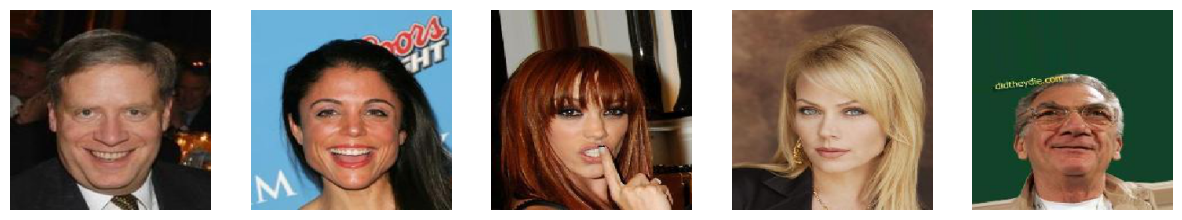

In [3]:
# Use ImageDataGenerator to load and preprocess the CelebA dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load and split the dataset into training and testing sets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=512,
    class_mode='input',
    subset='training'
)

test_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=512,
    class_mode='input',
    subset='validation'
)

# Normalize the images and split them into features and labels
x_train, _ = train_generator.next()
x_test, _ = test_generator.next()

x_image = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3]))
# Display the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(x_image[i])
    axes[i].axis('off')
plt.show()

## Variational autoencoder model

In [4]:
# from keras import backend as K 
# K.clear_session()

In [5]:
# Reshape the input images to match the expected shape in the VAE model
input_shape = (256, 256, 3)
x_train = np.reshape(x_train, (-1, *input_shape))
x_test = np.reshape(x_test, (-1, *input_shape))

batch_size = 16
latent_dim = 3

# Encoder
input_img = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(128, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3,padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

# Decoder
z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)
outputs = layers.Conv2DTranspose(3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [7]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss 
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])

In [8]:
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss= None, experimental_run_tf_function=False)

# Training the model
vae.fit(x=x_train, shuffle=True,y=None,epochs=20,batch_size=128,validation_data=(x_test, None))

Train on 512 samples, validate on 512 samples
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.6969 

C:\Users\21361495\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


512/512 [==============================] - 105s 206ms/sample - loss: 0.6969 - val_loss: 0.6922
Epoch 2/20
512/512 [==============================] - 92s 179ms/sample - loss: 0.6917 - val_loss: 0.6908
Epoch 3/20
512/512 [==============================] - 92s 179ms/sample - loss: 0.6902 - val_loss: 0.6886
Epoch 4/20
512/512 [==============================] - 97s 189ms/sample - loss: 0.6900 - val_loss: 0.6864
Epoch 5/20
512/512 [==============================] - 95s 186ms/sample - loss: 0.6860 - val_loss: 0.6841
Epoch 6/20
512/512 [==============================] - 87s 171ms/sample - loss: 0.6833 - val_loss: 0.6809
Epoch 7/20
512/512 [==============================] - 93s 182ms/sample - loss: 0.6798 - val_loss: 0.6757
Epoch 8/20
512/512 [==============================] - 90s 177ms/sample - loss: 0.6734 - val_loss: 0.6742
Epoch 9/20
512/512 [==============================] - 92s 179ms/sample - loss: 0.6692 - val_loss: 0.6588
Epoch 10/20
512/512 [==============================] - 90s 176ms/

# Reconstructing Original Images

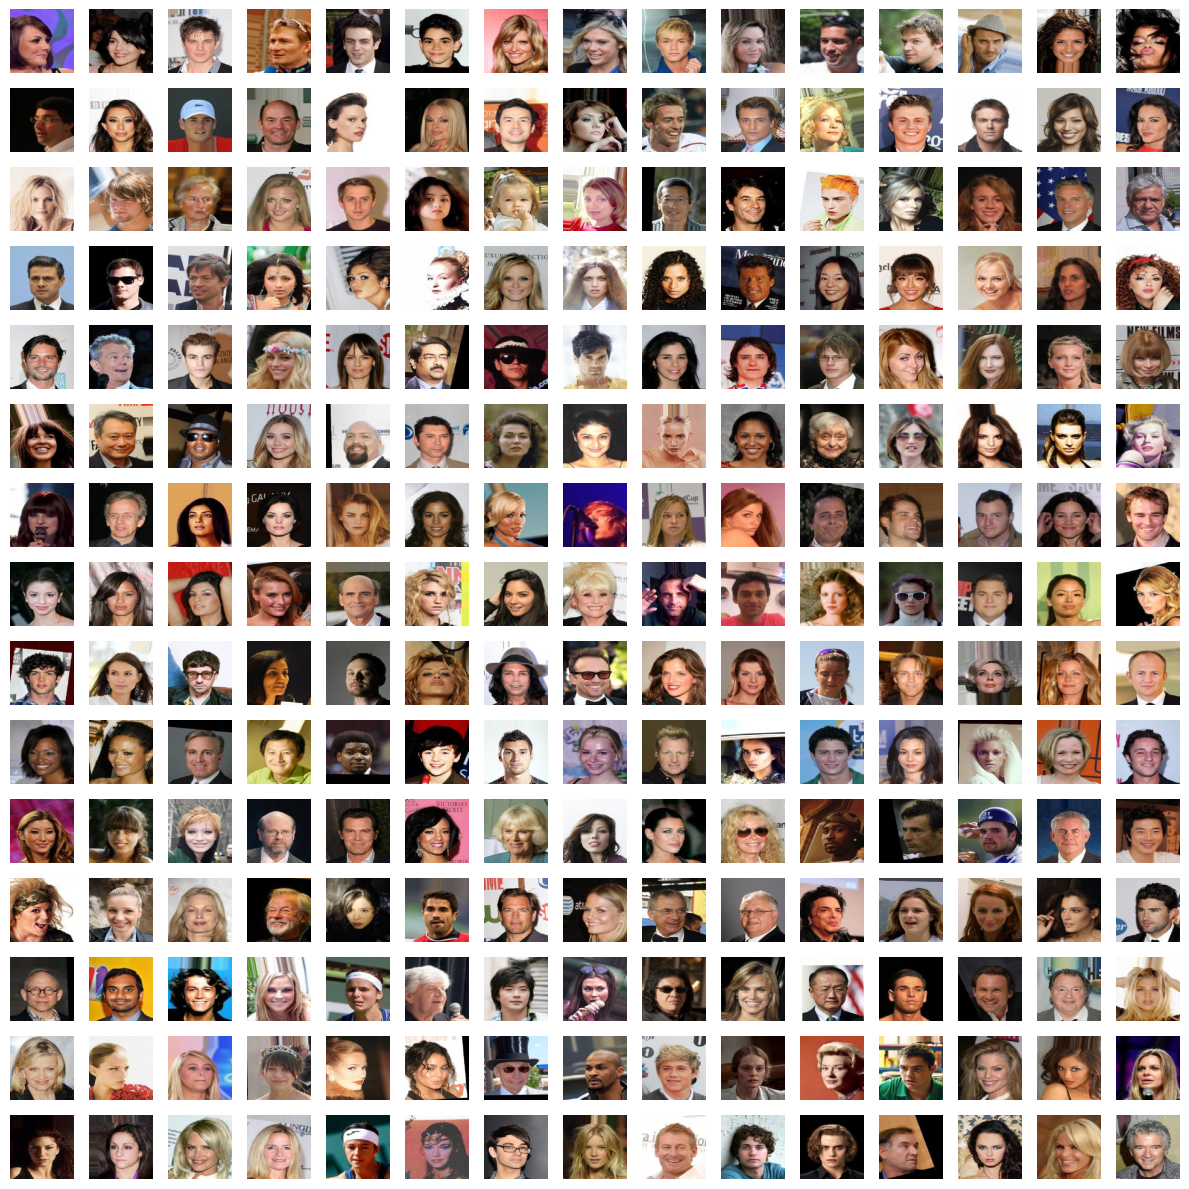

In [11]:
# Generate images using the trained VAE model
decoded_images = vae.predict(x_test)

# Rescale the decoded images to the range [0, 1]
decoded_images = np.clip(decoded_images, 0., 1.)

# Define the size of the grid
num_rows = 15
num_cols = 15

# Create a figure and axis object with the desired size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axis object to simplify indexing
axs = axs.flatten()

# Loop through the grid and plot each image
for i in range(num_rows * num_cols):
    # Reshape the original and reconstructed images to the original shape
    decoded_img = decoded_images[i].reshape(input_shape)
    
    # Plot the reconstructed image on the right side
    axs[i].imshow(decoded_img)
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# plt.savefig(result_dir+'Reconstructed_Images.png')

# Show the grid of images
plt.show()

# Generating new faces

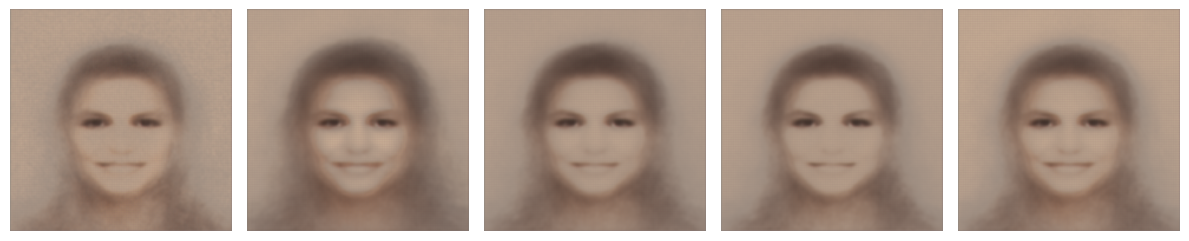

In [17]:
# Define the number of new faces to generate
num_faces = 5  # Number of faces to generate

# Generate random points in the latent space
latent_points = np.random.normal(size=(num_faces, 3))

# Decode the latent points to generate new faces
generated_faces = decoder.predict(latent_points)

# Rescale the generated faces to the range [0, 1]
generated_faces = np.clip(generated_faces, 0., 1.)

# Create a figure and axis object with the desired size
fig, axs = plt.subplots(1, num_faces, figsize=(12, 4))

# Loop through the generated faces and plot each one
for i in range(num_faces):
    # Reshape the generated face to the original shape
    generated_img = generated_faces[i].reshape(input_shape)
    
    # Plot the generated face
    axs[i].imshow(generated_img)
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the generated faces
plt.show()